In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.utils.data import download_file

from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = 10000

Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v20200428.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Representing On-Sky Positions with astropy.coordinates

In Astropy, the most common way of representing and working with sky coordinates is to use the `SkyCoord` object. A `SkyCoord` can be created directly from angles or arrays of angles with associated units.  

Create `SkyCoord` object for the center of the open cluster NGC 188.  
Assume for now, we know the sky coordinates of the cluster to be (12.11,85.26) degrees in ICRS coordinate frame. ICRS aka equatorial aka J2000 - is currently the most common astronomical coordinate frame for stellar or extragalactic astronomy, and is the default coordinate frame for `SkyCoord`.

In [2]:
ngc188_center = SkyCoord(12.11*u.deg,85.26*u.deg)
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

In [3]:
'''
Even though default frame is ICRS, it is generally recommended to explicitly specify
the frame your coordinates are in.
'''
ngc188_center = SkyCoord(12.11*u.deg,85.26*u.deg,frame='icrs')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

   The `SkyCoord` initializer will also accept string-formatted coordinates either as separate strings for RA and Dec or a single string.

In [4]:
SkyCoord('00h48m26.4s','85d15m36s',frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (12.11, 85.26)>

Alternative constructor for a SkyCoord object - calling with `SkyCoord.from_name()` with a name gives a new `SkyCoord` object.

In [5]:
ngc188_center = SkyCoord.from_name('NGC 188')
ngc188_center

<SkyCoord (ICRS): (ra, dec) in deg
    (12.10833333, 85.255)>

All `SkyCoord` objects have attributes that allow you to retrieve the coordinate component data, but the component names will change depending on the coordinate frame of the `SkyCoord` you have. In ICRS frame, the component names are lower-case abbreviations of RA `.ra` and Dec `.dec`.

In [6]:
ngc188_center.ra

<Longitude 12.10833333 deg>

In [7]:
ngc188_center.dec

<Latitude 85.255 deg>

In [8]:
ngc188_center.ra,ngc188_center.dec

(<Longitude 12.10833333 deg>, <Latitude 85.255 deg>)

With these objects, we can retrieve the coordinate components in different units using the `Quantity.to()` method:

In [9]:
ngc188_center.ra.to(u.hourangle)

<Longitude 0.80722222 hourangle>

In [10]:
ngc188_center.ra.to(u.radian)

<Longitude 0.21133028 rad>

In [11]:
ngc188_center.ra.to(u.degree)

<Longitude 12.10833333 deg>

## Querying the Gaia Archive to retrieve Coordinates of Stars in NGC 188

We can use the SkyCoord object for the center of NGC 188 with `astroquery` package to query different astronomical databases. We will use object `ngc188_center` to select sources from the Gaia Data Release 2 catalog around the position of center of NGC 188 to look for stars that might be member of the star cluster. We will use the `astroquery.gaia` subpackage for this.  

**This requires an internet connection.**

In [12]:
job = Gaia.cone_search_async(ngc188_center, radius=0.5*u.deg)
ngc188_table = job.get_results()

# Only keep the stars brighter than G = 19 magnitude
ngc188_table = ngc188_table[ngc188_table['phot_g_mean_mag']<19*u.mag]

INFO: Query finished. [astroquery.utils.tap.core]


In [13]:
cols = ['source_id',
 'ra',
 'dec',
 'parallax',
 'parallax_error',
 'pmra',
 'pmdec',
 'radial_velocity',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag']
ngc188_table[cols].write('gaia_results.fits', overwrite=True)

In [14]:
ngc188_table = QTable.read('gaia_results.fits')

In [15]:
len(ngc188_table)

4938

The returned `astropy.table` table object now contains 4938 stars from Gaia DR2 around the coordinate position of the center of NGC 188.

In [16]:
ngc188_table['ra']

<Quantity [12.09832966, 12.14694473, 12.05460389, ...,  6.15840244,
           11.71137094, 10.89179821] deg>

In [17]:
ngc188_table['dec']

<Quantity [85.25443128, 85.25475081, 85.25636896, ..., 85.32562027,
           85.74769043, 84.77264889] deg>

In [18]:
ngc188_gaia_coords = SkyCoord(ngc188_table['ra'],ngc188_table['dec'])
ngc188_gaia_coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(12.09832966, 85.25443128), (12.14694473, 85.25475081),
     (12.05460389, 85.25636896), ..., ( 6.15840244, 85.32562027),
     (11.71137094, 85.74769043), (10.89179821, 84.77264889)]>

## Including distance information in `SkyCoord`

ra, dec and distance means we have the full 3D position of the object. To pass in distance information, `SkyCoord` accepts the keyword argument `distance`. So, if we knew that the distance to NGC 188 is 1.96 kpc, we could also pass in a distance ( as a `Quantity` object) using this argument

In [19]:
ngc188_center_3d = SkyCoord(12.11*u.deg, 85.26*u.deg, distance=1.96*u.kpc)
ngc188_center_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (12.11, 85.26, 1.96)>

With the table of Gaia data we retrieved above for stars around NGC 188, `ngc188_table`, we also have parallax measurements for each star. For a precisely-measured parallax, the distance $d$ to a star can be obtained approximately as $d=1/parallax$. This only really works if the parallax error is small relative to the parallax. So if we want to use these parallaxes to get distance we first have to filter out stars that have low SNR parallaxes

In [20]:
parallax_snr = ngc188_table['parallax'] / ngc188_table['parallax_error']
ngc188_table_3d = ngc188_table[parallax_snr > 10]
len(ngc188_table_3d)

2053

The above selection on `parallax_snr` keeps stars that have a ~10 sigma parallax measurement, but this is an arbitrary selection threshold that you may want to tune or remove in your own use cases. This selection removed over half of the stars in our original table, but for the remaining stars we can be confident that converting the parallax measurement to distance is mostly safe.  

The default way of passing distance to a `SkyCoord` object, as above is to pass in a `Quantity` with a unit of length. However, `astropy.coordinates` also provide a specialized object, `Distance`, for handling common transformations of different distance presentations.

In [21]:
Distance(parallax=1*u.mas)

<Distance 1000. pc>

The catalog of stars we quried from Gaia contains parallax information in milli arc seconds (mas) so we can create a `Distance` object directly from these values.

In [22]:
gaia_dist = Distance(parallax = ngc188_table_3d['parallax'])

In [23]:
ngc188_coords_3d = SkyCoord(ra = ngc188_table_3d['ra'],
                           dec = ngc188_table_3d['dec'],
                            distance = gaia_dist)
ngc188_coords_3d

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(12.09832966, 85.25443128, 1109.14781668),
     (12.12843989, 85.26076889, 1835.66340989),
     (12.07705917, 85.24631009, 1974.19410857), ...,
     ( 6.13894786, 85.25954928, 2532.64969255),
     ( 6.15840244, 85.32562027, 1795.07434822),
     (11.71137094, 85.74769043,  367.13489233)]>

Use `matplotlib` to plot the sky positions of all these sources, colored by distance to emphasize the cluster stars

Text(0.5, 1.0, 'Gaia DR2 sources near NGC 188')

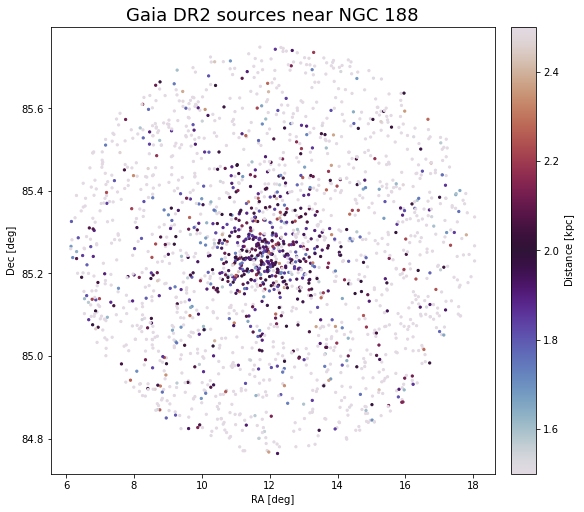

In [26]:
fig, ax = plt.subplots(figsize=(8,7),constrained_layout=True)
cs = ax.scatter(ngc188_coords_3d.ra.degree,
               ngc188_coords_3d.dec.degree,
               c = ngc188_coords_3d.distance.kpc,
               s = 5, vmin = 1.5, vmax = 2.5, cmap='twilight')
cb = fig.colorbar(cs)
cb.set_label(f'Distance [{u.kpc:latex_inline}]')

ax.set_xlabel('RA [deg]')
ax.set_ylabel('Dec [deg]')

ax.set_title('Gaia DR2 sources near NGC 188', fontsize=18)

We can compute the 3D separation between all of the Gaia sources and the cluster center.

In [27]:
sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
sep3d

<Distance [ 850.85219575,  124.33660295,   14.20219631, ...,  572.97077442,
            165.71210705, 1592.88153948] pc>

Using the 3D separation values, define a boolean mask to select candidate members of the cluster. Select all the stars within 50 pc of cluster center. How many candidate members of NGC188 do we have

In [28]:
ngc188_3d_mask = sep3d < 50*u.pc
ngc188_3d_mask.sum()

193